In [ ]:
pip install -q tensorflow==2.3.1

     |████████████████████████████████| 320.4MB 39kB/s 


In [ ]:
pip install -q tensorflow-quantum

     |████████████████████████████████| 5.9MB 2.7MB/s 
     |████████████████████████████████| 1.6MB 26.5MB/s 
     |████████████████████████████████| 5.6MB 49.7MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [ ]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [ ]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


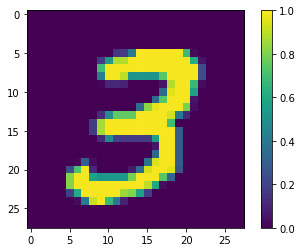

In [ ]:
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [ ]:
x_train_small = tf.image.resize(x_train, (3,3)).numpy()
x_test_small = tf.image.resize(x_test, (3,3)).numpy()

True


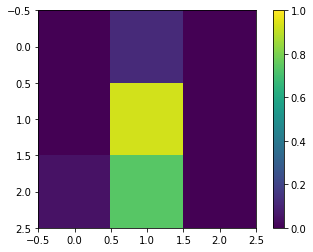

In [ ]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(3, 3)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))

    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

In [ ]:
x_train_circ[0]

(1, 1): ───X───

(2, 1): ───X───

In [ ]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[1, 1],
       [2, 1]])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


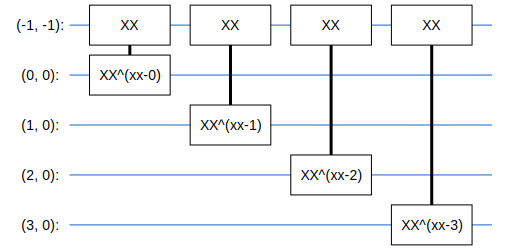

In [ ]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(3, 3)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()


In [ ]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 3
BATCH_SIZE = 128

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
import time
start_time = time.time()

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
377/377 [==============================] - 14s 36ms/step - loss: 0.8601 - hinge_accuracy: 0.6053 - val_loss: 0.5990 - val_hinge_accuracy: 0.7253
Epoch 2/3
377/377 [==============================] - 14s 37ms/step - loss: 0.4684 - hinge_accuracy: 0.7843 - val_loss: 0.3477 - val_hinge_accuracy: 0.8322
Epoch 3/3
62/62 [==============================] - 1s 18ms/step - loss: 0.3378 - hinge_accuracy: 0.8311


In [ ]:
print("--- %s saniye ---" % (time.time() - start_time))

--- 43.70973443984985 saniye ---


In [ ]:
qnn_accuracy = qnn_results[1]
qnn_accuracy

0.8311492204666138

In [ ]:
model.predict_classes(x_train_tfcirc[0:7])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


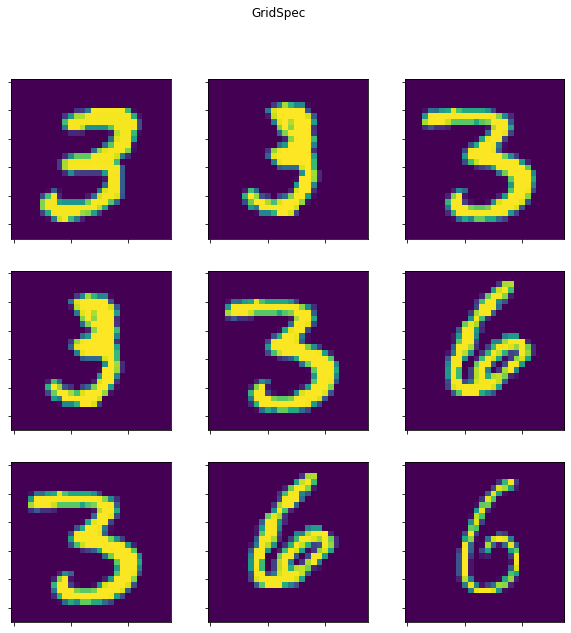

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(10, 10))

gs = GridSpec(3, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

for i in range(3):
  for j in range(3):
    ax = fig.add_subplot(gs[i, j])
    
    ax.imshow(x_train[i+j, :, :, 0])

fig.suptitle("GridSpec")
format_axes(fig)

plt.show()

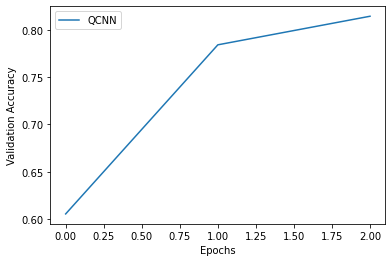

In [ ]:
plt.plot(qnn_history.history['hinge_accuracy'], label='QCNN')
#plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
#plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()